# Projeto Final - 2018  

## X-ray Pneumonia Classification

* Felipe Souza
* Pedro Augusto
* Rafael Dias
* Sergio Marinello


## Problema
### Xception - Transfer Learning  (NORMAL, PNEUMONIA BACTERIANA e PNEUMONIA VIRAL)<br>usando CNN simples com 3 camadas convolucionais + 1 densa + 1 densa para classificaço comã softmax

1. Healthy 
2. Pneumonia viral 
3. Pneumonia bacterial

### Data
#### Data Source
O dataset pode ser obtido em:
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia


#### Estrutura dos dados
O dataset contido em um arquivo  zip contém a estrutura de diretórios que provê a divisão de treinamento, validação e teste totalizando 5.863 imagens.
 
Abaixo temos a estrutura de pastas, que representa a divisão de teste, treinamento e validação e classe de cada imagem.

* /chest_xray/  
  * test/
    * NORMAL/
    * PNEUMONIA/
  * train/
    * NORMAL/
    * PNEUMONIA/
  * val/
    * NORMAL/
    * PNEUMONIA/


In [1]:
ROOT_DIR = "../input" #kaggle/git dir

# Import library
import os
if not (os.path.exists(ROOT_DIR)):
    print("Using git repository")
    ROOT_DIR = "./kowaslki/input" #colab dir
    if not (os.path.exists(ROOT_DIR)):    
        print("Checking out git repository")
        !git clone https://gitlab.com/rafa.apps/kowaslki.git
else:
    print("Using kaggle repository")
  

Using kaggle repository



```
# This is formatted as code
```

## Verificação dos dados

In [2]:
%matplotlib inline

# Basic math libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

MODEL_ID = "model_7"

# percentual do número de imagens usado por step no treinamento
TRAINING_PERCENTAGE = 0.20

# Take note that the .7z directory name is automatically converted to lowercase. 
INPUT_DIR = '%s/chest_xray/chest_xray' % ROOT_DIR


import os.path
# Ensure we're reading the directory correctly.
assert (os.path.exists(INPUT_DIR))

First, locate the main directory and display its content.

In [3]:
directory = os.listdir(INPUT_DIR)
print("Parent directory includes these folders:", directory)

('Parent directory includes these folders:', ['.DS_Store', 'test', 'train', 'val'])


The folders are split to include train, testing, as well as validation. Create variables pointing to these subfolders

In [4]:
train_folder = '%s/train/' % INPUT_DIR 
val_folder   = '%s/val/' % INPUT_DIR
test_folder  = '%s/test/' % INPUT_DIR

In [5]:
# train 
os.listdir(train_folder)
train_n = train_folder + 'NORMAL/'
train_p = train_folder + 'PNEUMONIA/'

val_n = val_folder + 'NORMAL/'
val_p = val_folder + 'PNEUMONIA/'

test_n = test_folder + 'NORMAL/'
test_p = test_folder + 'PNEUMONIA/'


# Normal 
print("TRAIN NORMAL:", len(os.listdir(train_n)))
print("TRAIN PNEUMONIA:", len(os.listdir(train_p)))
print("TRAIN TOTAL:", len(os.listdir(train_n)) + len(os.listdir(train_p)))


print("VALIDATION NORMAL:", len(os.listdir(val_n)))
print("VALIDATION PNEUMONIA:", len(os.listdir(val_p)))
print("VALIDATION TOTAL:", len(os.listdir(val_n)) + len(os.listdir(val_p)))

print("TEST NORMAL:", len(os.listdir(test_n)))
print("TEST PNEUMONIA:", len(os.listdir(test_p)))
print("TEST TOTAL:", len(os.listdir(test_n)) + len(os.listdir(test_p)))


train_samples = len(os.listdir(train_n)) + len(os.listdir(train_p))
validation_samples =  len(os.listdir(val_n)) + len(os.listdir(val_p))
test_samples = len(os.listdir(test_n)) + len(os.listdir(test_p))

('TRAIN NORMAL:', 1342)
('TRAIN PNEUMONIA:', 3876)
('TRAIN TOTAL:', 5218)
('VALIDATION NORMAL:', 9)
('VALIDATION PNEUMONIA:', 9)
('VALIDATION TOTAL:', 18)
('TEST NORMAL:', 234)
('TEST PNEUMONIA:', 390)
('TEST TOTAL:', 624)


## Métodos Utilitários do Dataset

In [6]:
nbClasses = 3

# classes
NORMAL=0
BACTERIA=1
VIRUS=2

def getLabelFromImgName(imgName):
    if "bacteria" in imgName:
        return BACTERIA
    if "virus" in imgName:
        return VIRUS
    return NORMAL

#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          width=8,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    f, ax = plt.subplots(1, 1, figsize=(width, width))
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes, rotation=90)
    ax.set_yticklabels(classes)
    ax.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    #axis[ax].axis('off')
    plt.tight_layout()
    return cm

## Carregando Dataset 

In [7]:
import pandas as df
def load_df(protocol, root_path):
    if protocol == 0 or protocol == 'original':
        df = pd.read_csv(os.path.join(root_path, 'protocol0.csv'))
    elif protocol == 1 or protocol == 'alternative':
        df = pd.read_csv(os.path.join(root_path, 'protocol_alternative.csv'))

    return df


### Decidimos utilizar nosso dataset balanceando as classes de validação

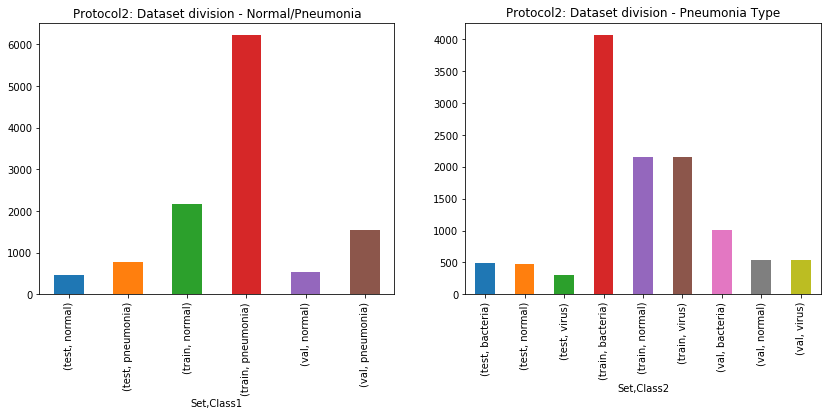

In [8]:
df_protocol2 = load_df('alternative', root_path="./")

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.set_title('Protocol2: Dataset division - Normal/Pneumonia')
ax2.set_title('Protocol2: Dataset division - Pneumonia Type')
_ = (df_protocol2.groupby(by=['Set', 'Class1']).size()).plot('bar', ax=ax1)
_ = (df_protocol2.groupby(by=['Set', 'Class2']).size()).plot('bar', ax=ax2)

In [9]:
from collections import defaultdict, Counter

for phase in df_protocol2.Set.unique():
    print('%s distribution: %s' % (phase, str(Counter(df_protocol2[df_protocol2.Set == phase].Class1))))
    print('%s distribution: %s' % (phase, str(Counter(df_protocol2[df_protocol2.Set == phase].Class2))))
    print('\n')


nan distribution: Counter()
nan distribution: Counter()


test distribution: Counter({'pneumonia': 780, 'normal': 468})
test distribution: Counter({'bacteria': 484, 'normal': 468, 'virus': 296})


train distribution: Counter({'pneumonia': 6212, 'normal': 2158})
train distribution: Counter({'bacteria': 4060, 'normal': 2158, 'virus': 2152})


val distribution: Counter({'pneumonia': 1554, 'normal': 540})
val distribution: Counter({'bacteria': 1016, 'normal': 540, 'virus': 538})




### Observamos que os de treinamento dados são altamente desbalanceados, além disso as dimensões das imagens não são sempre iguais.<br>Dessa forma, precisamos ponderar o peso para treinamento.<br><br>Além disso, observamos que o conjunto de validação é razoavelmente pequeno.

### Gera image loaders

In [10]:
img_width, img_height = 226,226

from keras import backend as K

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


In [11]:

def getDatasetSize(df, split='train', types=[NORMAL,BACTERIA,VIRUS], stratify='Class2', 
                    balanced=False, base_path=INPUT_DIR):
    if split not in ["train", "val", "test"]:
        raise ValueError(split + " not recognized. Did you mean 'train', 'val' or 'test'?")
    step = "%s  distribution" % split
    df = df[df.Set == split]
    
    #Get all file names for that split
    if not type(types) in (list, tuple):
        types = [types]
    
    indexes = {clazz: df[df[stratify] == clazz].index.tolist() for clazz in df[stratify].unique()}
    indexes = {k:l for k,l in indexes.items() if len(l) > 0}
    
    if balanced:
        lenght = min(map(len, indexes.values()))
    else:
        lenght = max(map(len, indexes.values()))

    indexes = {clazz: values[:lenght] for clazz, values in indexes.items()}
    
    n = sum([len(v) for v in indexes.values()])
    return n

def getDatasetFiles(df, split='train', types=[NORMAL,BACTERIA,VIRUS], stratify='Class2', 
                    balanced=False, shuffle=False, base_path=INPUT_DIR):
    if split not in ["train", "val", "test"]:
        raise ValueError(split + " not recognized. Did you mean 'train', 'val' or 'test'?")
    step = "%s  distribution" % split
    #df = df[df.Set == step]
    
    #Get all file names for that split
    if not type(types) in (list, tuple):
        types = [types]
    
    indexes = {clazz: df[df[stratify] == clazz].index.tolist() for clazz in df[stratify].unique()}
    indexes = {k:l for k,l in indexes.items() if len(l) > 0}
    
    if balanced:
        lenght = min(map(len, indexes.values()))
    else:
        lenght = max(map(len, indexes.values()))

    if shuffle:
        indexes = {clazz: np.random.choice(values, size=lenght, replace=True) for clazz, values in indexes.items()}
    else:
        indexes = {clazz: values[:lenght] for clazz, values in indexes.items()}
    
    import glob
    fileNames = {}
    if NORMAL in types:
        fileNames[NORMAL] = ["%s/%s" % (base_path, df["Path"][df[df.index == row_idx].index[0]]) for row_idx in indexes["normal"]]
    if BACTERIA in types:        
        fileNames[BACTERIA] = ["%s/%s" % (base_path, df["Path"][df[df.index == row_idx].index[0]]) for row_idx in indexes["bacteria"]]
    if VIRUS in types:
        fileNames[VIRUS] = ["%s/%s" % (base_path, df["Path"][df[df.index == row_idx].index[0]]) for row_idx in indexes["virus"]]
        
    fileNames = {clazz: [v for v in values] for clazz, values in fileNames.items()}
    
    return fileNames


#Read our dataset in batches
def loadDatasetInBatches(df = None, split="train", batch_size=32, 
                         datasetDir=INPUT_DIR,
                         nb_classes=nbClasses, 
                         stratify=None,
                         image_shape=(112, 112), 
                         dataAugmentator=None, 
                         shuffle=True, 
                         balanced=False,
                         normalization_fn=None,
                         load_and_preprocess_fn=None, 
                         path_and_class_translation_fn=None):
    
    from keras.preprocessing.image import load_img, img_to_array
    from random import sample
    from keras.utils import np_utils

    if split not in ["train", "val", "test"]:
        raise ValueError(split + " not recognized. Did you mean 'train', 'val' or 'test'?")
            
    splitDir = os.path.join(datasetDir, split)
    #Get all file names for that split
    all_files = getDatasetFiles(df, split=split, shuffle=shuffle, balanced=balanced)
    
    while True:
        fileNames = {}
        for k,class_fileNames in all_files.items():
            # shuffle files and append root folder path
            shuffledFileNames = sample(class_fileNames, len(class_fileNames)) #shuffle images in each epoch
            fileNames[k] = shuffledFileNames

        TOTAL_FILES = sum([len(v) for v in fileNames.values()])
        if TOTAL_FILES == 0:
            raise Exception("Missing files for dir: %s" % splitDir)

        #loop of one epoch
        batch, labelList = [], []
        nInBatch = 0
        next_class = 0
        
        idx_per_class = {c:0 for c in range(nbClasses)}
        
        for idx in range(TOTAL_FILES):
            # next class
            next_class = idx % nbClasses
            # class files
            class_files = fileNames[next_class]
            if len(class_files) == 0:
                # ignore empty class
                continue

            # ID for next file for this class
            class_idx = idx_per_class[next_class]
            
            next_imagepath = class_files[class_idx]
            # increment the ID to be used at next iteration
            idx_per_class[next_class] = (class_idx + 1) % len(class_files)
                
            #print(next_imagepath)
            img = load_and_preprocess_fn(next_imagepath)
            if img is None:
                raise Exception("Unable to load image path: %s" % next_imagepath)
                
            if dataAugmentator:
                img = dataAugmentator(img)            
            if normalization_fn:
                img = normalization_fn(img)
                
            label = np_utils.to_categorical(getLabelFromImgName(next_imagepath), nbClasses)

            batch.append(img)
            labelList.append(label)
            nInBatch += 1
            #if we already have one batch, yields it
            if nInBatch >= batch_size:
                yield np.array(batch), np.array(labelList)
                batch, labelList = [], []
                nInBatch = 0
        
        #yield the remaining of the batch
        if nInBatch > 0:
            yield np.array(batch), np.array(labelList)

#test
#getDatasetFiles(df_protocol2, split="train")

In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from functools import partial
import cv2

IMAGE_SIZE = img_width, img_height

# this is the augmentation configuration we will use for training
# For test we don't need to apply transformation
test_datagen = None

def resize_img(img, resize=(112, 112)):
    return cv2.resize(img, resize) 

def img_normalization(img):
    if img is None:
        raise Exception("No input image")
    img = img.astype(np.float32)
    img /= 127.5
    img -= 1.0
    return img

def normalization_fn(img, resize=(112, 112)):
    img = img_normalization(img)
    img = resize_img(img, resize=resize)
    return img


def load_and_preprocess_rgb(path):
    img = cv2.imread(path)

    return img

def path_and_one_hot_class2_translation_fn(row, nb_classes=3, base_path=INPUT_DIR):
    class_map = {'normal': 0, 'bacteria': 1, 'virus': 2}
    return "%s/%s" % (base_path, row.Path), np_utils.to_categorical(class_map[row.Class2], num_classes=nb_classes)


train_generator = loadDatasetInBatches(df=df_protocol2[df_protocol2.Set == 'train'], 
                                        split='train',
                                        batch_size=32,
                                        stratify='Class2', 
                                        image_shape=input_shape, 
                                        normalization_fn=partial(normalization_fn, resize=IMAGE_SIZE),
                                        nb_classes=nbClasses, shuffle=True, 
                                        load_and_preprocess_fn=load_and_preprocess_rgb,
                                        dataAugmentator=None,
                                        path_and_class_translation_fn=partial(path_and_one_hot_class2_translation_fn,
                                                                           nb_classes=nbClasses,
                                                                           base_path=INPUT_DIR) )

val_generator = loadDatasetInBatches(df=df_protocol2[df_protocol2.Set == 'val'],
                                     split='val',
                                       batch_size=32, stratify='Class2', 
                                       image_shape=input_shape, 
                                       normalization_fn=partial(normalization_fn, resize=IMAGE_SIZE),
                                       nb_classes=nbClasses, shuffle=True, 
                                       load_and_preprocess_fn=load_and_preprocess_rgb,
                                       dataAugmentator=None,
                                       path_and_class_translation_fn=partial(path_and_one_hot_class2_translation_fn,
                                                                             nb_classes=nbClasses,
                                                                             base_path=INPUT_DIR) )

test_generator = loadDatasetInBatches(df=df_protocol2[df_protocol2.Set == 'test'],
                                      split='test',
                                        batch_size=32, stratify='Class2', 
                                        image_shape=input_shape,
                                        nb_classes=nbClasses, 
                                        normalization_fn=partial(normalization_fn, resize=IMAGE_SIZE),
                                        shuffle=True, 
                                        load_and_preprocess_fn=load_and_preprocess_rgb,
                                        dataAugmentator=None,
                                        path_and_class_translation_fn=partial(path_and_one_hot_class2_translation_fn,
                                                                             nb_classes=nbClasses,
                                                                             base_path=INPUT_DIR) )



# Gera o modelo

## 7.2 Utilizando regularização

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

from keras.applications import xception
from keras.models import Model
from keras.regularizers import l2

base_model = xception.Xception(weights='imagenet', input_shape=input_shape)
print([(i,base_model.layers[i].name) for i in range(len(base_model.layers))])

# freeze layers for training
for i in range(106):
    base_model.layers[i].trainable = False
    
X = base_model.get_layer('avg_pool').output


X = Dense(128, kernel_regularizer=l2(0.01))(X)
X = Activation('relu')(X)
X = Dropout(0.5)(X)
X = Dense(nbClasses)(X)
X = Activation('softmax', name="prediction")(X)

model = Model(inputs=base_model.input, outputs=X)

[(0, 'input_1'), (1, 'block1_conv1'), (2, 'block1_conv1_bn'), (3, 'block1_conv1_act'), (4, 'block1_conv2'), (5, 'block1_conv2_bn'), (6, 'block1_conv2_act'), (7, 'block2_sepconv1'), (8, 'block2_sepconv1_bn'), (9, 'block2_sepconv2_act'), (10, 'block2_sepconv2'), (11, 'block2_sepconv2_bn'), (12, 'conv2d_1'), (13, 'block2_pool'), (14, 'batch_normalization_1'), (15, 'add_1'), (16, 'block3_sepconv1_act'), (17, 'block3_sepconv1'), (18, 'block3_sepconv1_bn'), (19, 'block3_sepconv2_act'), (20, 'block3_sepconv2'), (21, 'block3_sepconv2_bn'), (22, 'conv2d_2'), (23, 'block3_pool'), (24, 'batch_normalization_2'), (25, 'add_2'), (26, 'block4_sepconv1_act'), (27, 'block4_sepconv1'), (28, 'block4_sepconv1_bn'), (29, 'block4_sepconv2_act'), (30, 'block4_sepconv2'), (31, 'block4_sepconv2_bn'), (32, 'conv2d_3'), (33, 'block4_pool'), (34, 'batch_normalization_3'), (35, 'add_3'), (36, 'block5_sepconv1_act'), (37, 'block5_sepconv1'), (38, 'block5_sepconv1_bn'), (39, 'block5_sepconv2_act'), (40, 'block5_sepc

## Compila

In [14]:
import keras.optimizers as optimizers

# Compilation
sgd = optimizers.SGD(lr=0.001, nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"]) 

model.load_weights("%s.1_best_val_acc.weights" % MODEL_ID)


## Treinamento

In [15]:
epochs = 50
batch_size = 64

import keras.callbacks
checkpoints = keras.callbacks.ModelCheckpoint("./%s.2_best_val_acc.weights" % MODEL_ID, monitor='val_acc', verbose=1,
                                              save_best_only=True, save_weights_only=True, mode='auto', period=1)
earlyStopcallback = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0,
                                                  patience=5, verbose=1, mode='auto')

callbacks = [checkpoints, earlyStopcallback]

#Fit nos dados
history = model.fit_generator(train_generator,
                              steps_per_epoch=train_samples // float(batch_size),
                              epochs=epochs,
                              validation_data=val_generator,
                              validation_steps=max((validation_samples // float(batch_size)), 1),
                              callbacks=callbacks)

#model.save_weights('baseline_cnn.h5')

Epoch 1/50
81/81 [==============================] - 74s 916ms/step - loss: 3.4713 - acc: 0.4344 - val_loss: 3.4086 - val_acc: 0.5312
Epoch 2/50
81/81 [==============================] - 56s 689ms/step - loss: 3.4421 - acc: 0.4753 - val_loss: 3.3663 - val_acc: 0.5938
Epoch 3/50
81/81 [==============================] - 58s 711ms/step - loss: 3.3909 - acc: 0.5355 - val_loss: 3.4231 - val_acc: 0.5625
Epoch 4/50
81/81 [==============================] - 56s 691ms/step - loss: 3.3455 - acc: 0.5864 - val_loss: 3.3618 - val_acc: 0.5625
Epoch 5/50
81/81 [==============================] - 57s 699ms/step - loss: 3.2961 - acc: 0.6218 - val_loss: 3.2765 - val_acc: 0.6562
Epoch 6/50
81/81 [==============================] - 56s 688ms/step - loss: 3.2458 - acc: 0.6424 - val_loss: 3.2488 - val_acc: 0.6562
Epoch 7/50
81/81 [==============================] - 56s 692ms/step - loss: 3.2099 - acc: 0.6728 - val_loss: 3.1511 - val_acc: 0.7188
Epoch 8/50
81/81 [==============================] - 57s 703ms/step - 

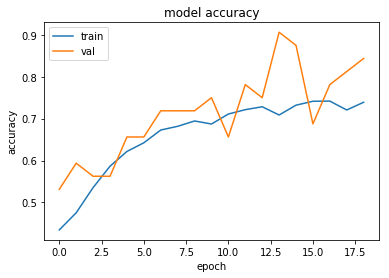

In [16]:
model.load_weights("%s.2_best_val_acc.weights" % MODEL_ID)

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

In [17]:
# evaluate the model
scores = model.evaluate_generator(val_generator,                
                                  steps=max((validation_samples // float(batch_size)), 1))
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


acc: 78.12%


# Avalia teste

In [18]:
# evaluate the model
scores = model.evaluate_generator(test_generator,                
                                  steps=max((test_samples // float(batch_size)), 1))
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


acc: 76.39%


#### 

In [19]:
model = None
import gc
gc.collect()

2787

# 7.3 Adicionando mais camadas densas para aumentando o grau a complexidade do modelo

In [20]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

from keras.applications import xception
from keras.models import Model

from keras.regularizers import l2

base_model = xception.Xception(weights='imagenet', input_shape=input_shape)
print([(i,base_model.layers[i].name) for i in range(len(base_model.layers))])

for i in range(106):
    base_model.layers[i].trainable = False
    
X = base_model.get_layer('avg_pool').output

X = Dense(128, kernel_regularizer=l2(0.01))(X)
X = Activation('relu')(X)
X = Dropout(0.5)(X)
X = Dense(128, kernel_regularizer=l2(0.01))(X)
X = Activation('relu')(X)
X = Dropout(0.5)(X)

X = Dense(nbClasses)(X)
X = Activation('softmax', name="prediction")(X)

model = Model(inputs=base_model.input, outputs=X)


# Compilation
sgd = optimizers.SGD(lr=0.001, nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"]) 

[(0, 'input_2'), (1, 'block1_conv1'), (2, 'block1_conv1_bn'), (3, 'block1_conv1_act'), (4, 'block1_conv2'), (5, 'block1_conv2_bn'), (6, 'block1_conv2_act'), (7, 'block2_sepconv1'), (8, 'block2_sepconv1_bn'), (9, 'block2_sepconv2_act'), (10, 'block2_sepconv2'), (11, 'block2_sepconv2_bn'), (12, 'conv2d_5'), (13, 'block2_pool'), (14, 'batch_normalization_5'), (15, 'add_13'), (16, 'block3_sepconv1_act'), (17, 'block3_sepconv1'), (18, 'block3_sepconv1_bn'), (19, 'block3_sepconv2_act'), (20, 'block3_sepconv2'), (21, 'block3_sepconv2_bn'), (22, 'conv2d_6'), (23, 'block3_pool'), (24, 'batch_normalization_6'), (25, 'add_14'), (26, 'block4_sepconv1_act'), (27, 'block4_sepconv1'), (28, 'block4_sepconv1_bn'), (29, 'block4_sepconv2_act'), (30, 'block4_sepconv2'), (31, 'block4_sepconv2_bn'), (32, 'conv2d_7'), (33, 'block4_pool'), (34, 'batch_normalization_7'), (35, 'add_15'), (36, 'block5_sepconv1_act'), (37, 'block5_sepconv1'), (38, 'block5_sepconv1_bn'), (39, 'block5_sepconv2_act'), (40, 'block5_s

In [21]:
epochs = 50
batch_size = 64

import keras.callbacks
checkpoints = keras.callbacks.ModelCheckpoint("./%s.3_best_val_acc.weights" % MODEL_ID, monitor='val_acc', verbose=1,
                                              save_best_only=True, save_weights_only=True, mode='auto', period=1)
earlyStopcallback = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0,
                                                  patience=5, verbose=1, mode='auto')

callbacks = [checkpoints, earlyStopcallback]

#Fit nos dados
history = model.fit_generator(train_generator,
                              steps_per_epoch=train_samples // float(batch_size),
                              epochs=epochs,
                              validation_data=val_generator,
                              validation_steps=max((validation_samples // float(batch_size)), 1),
                              callbacks=callbacks)

#model.save_weights('baseline_cnn.h5')

Epoch 1/50
326/326 [==============================] - 255s 783ms/step - loss: 4.7526 - acc: 0.3697 - val_loss: 4.6957 - val_acc: 0.4375
Epoch 2/50
326/326 [==============================] - 244s 749ms/step - loss: 4.6605 - acc: 0.4367 - val_loss: 4.5902 - val_acc: 0.5625
Epoch 3/50
326/326 [==============================] - 242s 741ms/step - loss: 4.5615 - acc: 0.5163 - val_loss: 4.4314 - val_acc: 0.8438
Epoch 4/50
326/326 [==============================] - 234s 719ms/step - loss: 4.4575 - acc: 0.5737 - val_loss: 4.3929 - val_acc: 0.5625
Epoch 5/50
326/326 [==============================] - 239s 732ms/step - loss: 4.3368 - acc: 0.6098 - val_loss: 4.1410 - val_acc: 0.7188
Epoch 6/50
326/326 [==============================] - 238s 730ms/step - loss: 4.2279 - acc: 0.6401 - val_loss: 4.0526 - val_acc: 0.8438
Epoch 7/50
326/326 [==============================] - 240s 737ms/step - loss: 4.1325 - acc: 0.6538 - val_loss: 4.0079 - val_acc: 0.8438
Epoch 8/50
326/326 [============================

In [22]:
# Load best weights
model.load_weights("%s.3_best_val_acc.weights" % MODEL_ID)

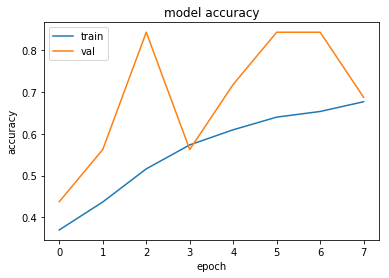

In [23]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

In [25]:
# evaluate the model
scores = model.evaluate_generator(val_generator,                
                                  steps=max((validation_samples // float(batch_size)), 1))
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


acc: 62.50%


In [26]:
# evaluate the model
scores = model.evaluate_generator(test_generator,                
                                  steps=max((test_samples // float(batch_size)), 1))
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


acc: 68.16%


# Model 7.4

In [27]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

from keras.applications import xception
from keras.models import Model

from keras.regularizers import l2

base_model = xception.Xception(weights='imagenet', input_shape=input_shape)
print([(i,base_model.layers[i].name) for i in range(len(base_model.layers))])

for i in range(106):
    base_model.layers[i].trainable = False
    
X = base_model.get_layer('avg_pool').output

X = Dense(256, kernel_regularizer=l2(0.01))(X)
X = Activation('relu')(X)
X = Dropout(0.5)(X)
X = Dense(256, kernel_regularizer=l2(0.01))(X)
X = Activation('relu')(X)
X = Dropout(0.5)(X)

X = Dense(nbClasses)(X)
X = Activation('softmax', name="prediction")(X)

model = Model(inputs=base_model.input, outputs=X)


# Compilation
sgd = optimizers.SGD(lr=0.001, nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"]) 

[(0, 'input_3'), (1, 'block1_conv1'), (2, 'block1_conv1_bn'), (3, 'block1_conv1_act'), (4, 'block1_conv2'), (5, 'block1_conv2_bn'), (6, 'block1_conv2_act'), (7, 'block2_sepconv1'), (8, 'block2_sepconv1_bn'), (9, 'block2_sepconv2_act'), (10, 'block2_sepconv2'), (11, 'block2_sepconv2_bn'), (12, 'conv2d_9'), (13, 'block2_pool'), (14, 'batch_normalization_9'), (15, 'add_25'), (16, 'block3_sepconv1_act'), (17, 'block3_sepconv1'), (18, 'block3_sepconv1_bn'), (19, 'block3_sepconv2_act'), (20, 'block3_sepconv2'), (21, 'block3_sepconv2_bn'), (22, 'conv2d_10'), (23, 'block3_pool'), (24, 'batch_normalization_10'), (25, 'add_26'), (26, 'block4_sepconv1_act'), (27, 'block4_sepconv1'), (28, 'block4_sepconv1_bn'), (29, 'block4_sepconv2_act'), (30, 'block4_sepconv2'), (31, 'block4_sepconv2_bn'), (32, 'conv2d_11'), (33, 'block4_pool'), (34, 'batch_normalization_11'), (35, 'add_27'), (36, 'block5_sepconv1_act'), (37, 'block5_sepconv1'), (38, 'block5_sepconv1_bn'), (39, 'block5_sepconv2_act'), (40, 'bloc

In [28]:
epochs = 50
batch_size = 64

import keras.callbacks
checkpoints = keras.callbacks.ModelCheckpoint("./%s.4_best_val_acc.weights" % MODEL_ID, monitor='val_acc', verbose=1,
                                              save_best_only=True, save_weights_only=True, mode='auto', period=1)
earlyStopcallback = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0,
                                                  patience=5, verbose=1, mode='auto')

callbacks = [checkpoints, earlyStopcallback]

#Fit nos dados
history = model.fit_generator(train_generator,
                              steps_per_epoch=train_samples // float(batch_size),
                              epochs=epochs,
                              validation_data=val_generator,
                              validation_steps=max((validation_samples // float(batch_size)), 1),
                              callbacks=callbacks)

#model.save_weights('baseline_cnn.h5')

Epoch 1/50
81/81 [==============================] - 87s 1s/step - loss: 8.2520 - acc: 0.3471 - val_loss: 8.1960 - val_acc: 0.4375
Epoch 2/50
81/81 [==============================] - 67s 823ms/step - loss: 8.2184 - acc: 0.3573 - val_loss: 8.1225 - val_acc: 0.6250
Epoch 3/50
81/81 [==============================] - 72s 891ms/step - loss: 8.1808 - acc: 0.3854 - val_loss: 8.1536 - val_acc: 0.4375
Epoch 4/50
81/81 [==============================] - 68s 833ms/step - loss: 8.1343 - acc: 0.4186 - val_loss: 8.1208 - val_acc: 0.6250
Epoch 5/50
72/81 [=========================>....] - ETA: 7s - loss: 8.1146 - acc: 0.4227

KeyboardInterrupt: 

In [ ]:
# Load best weights
model.load_weights("%s.4_best_val_acc.weights" % MODEL_ID)

In [ ]:
# evaluate the model
scores = model.evaluate_generator(val_generator,                
                                  steps=max((validation_samples // float(batch_size)), 1))
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [ ]:
# evaluate the model
scores = model.evaluate_generator(test_generator,                
                                  steps=max((test_samples // float(batch_size)), 1))
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))